This notebook models classifiers to detect if a given county is a close result in the 2016 election (labeled "swing") or not (labeled "safe"). Interpretable models will be used to investigate which features indicate a battleground county.

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## sklearn

In [157]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# tuning
from sklearn.model_selection import GridSearchCV
# pca
from sklearn import decomposition
# models
from sklearn.linear_model import LogisticRegression

## other

In [3]:
# upsampling
from imblearn import over_sampling
from imblearn.pipeline import Pipeline as imbPipeline

## Plot Settings

In [4]:
# format style
plt.style.use('fivethirtyeight')
# lineweight
plt.rc('lines', linewidth=3)
# figure size
plt.rc('figure', figsize=(12, 7))
# title fontsize
plt.rc('axes', titlesize=22) 
# axes label fontsize
plt.rc('axes', labelsize=18)
# axes values fontsize
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
# legend fontsize
plt.rc('legend', fontsize=16)

# Custom Functions

## Space Log
Return range of numbers between two values in a log scale

In [5]:
def space_log(start, stop, number):
    return(np.exp(np.linspace(np.log(start), np.log(stop), number)))

# Data

In [6]:
df = pd.read_pickle('data/dataframe.pkl')
df.head()

,population,growth,households,median_age,per_cap_income,hh_income,unempl_rate,poverty_rate,hs_rate,college_rate,density,white_rate,hisp_rate,close_elect
0,55504.0,1.7,20800.0,37.8,39721.0,54487.0,3.9,13.5,87.6,24.6,93.371913,0.762305,0.025512,0
1,212628.0,16.7,75149.0,42.3,41286.0,56460.0,4.0,11.7,90.0,29.5,133.746808,0.810999,0.040973,0
2,25270.0,-8.0,9122.0,38.7,31788.0,32884.0,5.9,29.9,73.8,12.9,28.557545,0.491888,0.045390,0
3,22668.0,-1.1,7048.0,40.2,29264.0,43079.0,4.4,20.1,80.7,12.0,36.409779,0.766278,0.022146,0
4,58013.0,1.2,20619.0,40.8,31470.0,47213.0,4.0,14.1,80.0,13.0,89.973324,0.949322,0.086808,0


## NaN values

In [7]:
# drop rows with nans
df = df.dropna()

## EDA

In [8]:
# sns.pairplot(df);

In [9]:
# inspect mean values of features for not-close vs close outcomes
df.groupby('close_elect').mean()

,population,growth,households,median_age,per_cap_income,hh_income,unempl_rate,poverty_rate,hs_rate,college_rate,density,white_rate,hisp_rate
close_elect,,,,,,,,,,,,,
0,97754.622861,0.673854,35383.793292,41.180151,40647.942847,49173.193018,4.611328,15.914203,85.657392,20.269884,251.164202,0.838362,0.088684
1,213686.159236,2.568153,77334.891720,38.888535,42207.388535,53773.019108,4.530573,15.549045,88.495541,27.620382,317.779807,0.760183,0.095176


In [10]:
close = (df['close_elect'] == 1).sum()
not_close = (df['close_elect'] == 0).sum()

In [11]:
# baseline, null model accuracy - guess '0' every time
(df['close_elect'] == 0).sum() / len(df)

0.9490094186424164

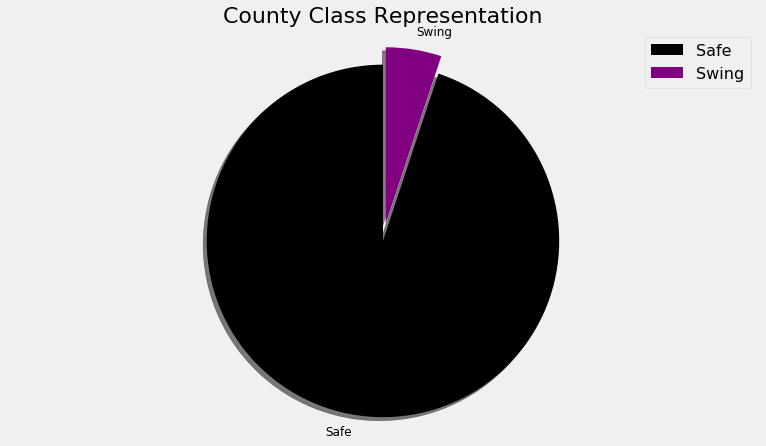

In [12]:
# plot pie chart

sizes = [not_close, close]
explode = (0, 0.1)
colors = ['black', 'purple']

fig, ax = plt.subplots()
ax.pie(sizes, labels=['Safe', 'Swing'], explode=explode, colors=colors,
        shadow=True, startangle=90)
ax.axis('equal') # circle shape
ax.set_title('County Class Representation')
ax.legend();

# plt.savefig("presentation/class_rep.png");

**Notes**
- Data is extremely unbalanced  
- "Safe" counties are much more prevalent in data (about 95% of observations)
- A model could attain 95% accuracy by always predicting "safe" counties!

# Pre-processing

In [13]:
# initialize feature dataframe and observed outcome
X = df.iloc[:, 0:13]
y = df.iloc[:, 13]

## Train/test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

## Scaling

In [15]:
# scale data to have mean = 0 and variance = 1
scaler = preprocessing.StandardScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

## Principle Component Analysis (PCA)
Reduce dimensionality of data to 2-D so that grouping trends can potentially be visualized

In [16]:
# decomposition to 2-D
pca = decomposition.PCA(n_components=2)
pca_features = pca.fit_transform(X_train_scl)

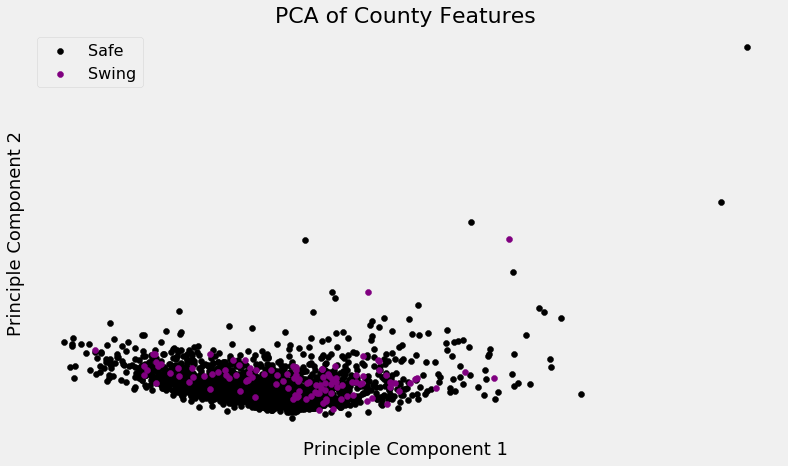

In [17]:
# plot components
class_labels = ['Safe', 'Swing']
colors = ['black', 'purple']

plt.figure()
for i, label in enumerate(class_labels):
    plt.scatter(pca_features[y_train == i, 0], pca_features[y_train == i, 1],
                label=label, c=colors[i])
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('PCA of County Features')
plt.xticks([]) # component valuables not interpretable
plt.yticks([]) # component valuables not interpretable
plt.legend();

# Logistic Regression Modeling

## Initial Model

In [75]:
# model pipeline includes scaling
log_pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression())
])

In [76]:
log_pipe.fit(X_train, y_train)
log_pred = log_pipe.predict(X_test)

In [77]:
print(metrics.classification_report(y_test, log_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       729
          1       0.00      0.00      0.00        41

avg / total       0.90      0.95      0.92       770



/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [78]:
metrics.confusion_matrix(y_test, log_pred)

array([[729,   0],
       [ 41,   0]])

**Notes**
- model does not accurately predict any swing counties  
    - this is a result of the severe imbalance of classes in the dataset
- recall is to be prioritized
    - this will help the model capture more swing counties (label 1)
    - may result in more false positives and reduced overall accuracy

## Tuning with GridSearch
Tune model hyperparameter for optimal model performance

In [79]:
# try range of values for C and penalty hyperparameters
hyperparams = {'model__penalty':['l1', 'l2'], 'model__C': space_log(0.001, 100, 15)}

In [80]:
# tune model pipeline for recall
log_gs = GridSearchCV(log_pipe, hyperparams, cv=10, scoring='recall')

In [81]:
log_gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model__penalty': ['l1', 'l2'], 'model__C': array([1.00000e-03, 2.27585e-03, 5.17947e-03, 1.17877e-02, 2.68270e-02,
       6.10540e-02, 1.38950e-01, 3.16228e-01, 7.19686e-01, 1.63789e+00,
       3.72759e+00, 8.48343e+00, 1.93070e+01, 4.39397e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [89]:
# assign best hyperparameter values from tuning
best_penalty = log_gs.best_params_['model__penalty']
best_C = log_gs.best_params_['model__C']

In [90]:
# model pipeline with optimal hyperparameters
log_pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression(penalty=best_penalty, C=best_C))
])

In [91]:
log_pipe.fit(X_train, y_train)
log_pred = log_pipe.predict(X_test)

In [92]:
print(metrics.classification_report(y_test, log_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       729
          1       0.00      0.00      0.00        41

avg / total       0.90      0.95      0.92       770



/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [93]:
metrics.confusion_matrix(y_test, log_pred)

array([[729,   0],
       [ 41,   0]])

**Notes**  
Tuning did not increase recall for swing counties

## Balanced Weights
Modifies "weights" of classes in algorithm's cost function to place greater importance on minority class  
Balanced weights are inversly proportional to the frequency of class observations

In [112]:
# model pipeline with class weights set to balanced
log_pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced'))
])

In [113]:
log_pipe.fit(X_train, y_train)
log_predict = log_pipe.predict(X_test)

In [114]:
print(metrics.classification_report(y_test, log_predict))

             precision    recall  f1-score   support

          0       0.98      0.77      0.86       729
          1       0.15      0.71      0.24        41

avg / total       0.93      0.77      0.83       770



In [115]:
metrics.confusion_matrix(y_test, log_predict)

array([[562, 167],
       [ 12,  29]])

**Notes**  
This greatly increased recall for label 1 classification  
Try tuning this model

In [116]:
hyperparams = {'model__penalty':['l1', 'l2'], 'model__C': space_log(0.001, 100, 15)}
log_gs = GridSearchCV(log_pipe, hyperparams, cv=10, scoring='recall')
log_gs.fit(X_train, y_train)
best_penalty_bal = log_gs.best_params_['model__penalty']
best_C_bal = log_gs.best_params_['model__C']

In [117]:
# update hyperparameters in pipeline
log_pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression(penalty=best_penalty_bal, C=best_C_bal, class_weight='balanced'))
])

In [118]:
log_pipe.fit(X_train, y_train)
log_pred = log_pipe.predict(X_test)

In [119]:
print(metrics.classification_report(y_test, log_pred))

             precision    recall  f1-score   support

          0       0.98      0.71      0.82       729
          1       0.13      0.78      0.22        41

avg / total       0.94      0.71      0.79       770



In [120]:
metrics.confusion_matrix(y_test, log_pred)

array([[516, 213],
       [  9,  32]])

**Notes**  
Model performance increased with tuning

## Synthetic Minority Over-sampling Technique (SMOTE)
Oversampling method that generates synthetic samples of the minority class

In [122]:
# model pipeline with SMOTE applied
log_pipe = imbPipeline([
    ('oversample', over_sampling.SMOTE(random_state=0)),
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression())    
])

In [123]:
log_pipe.fit(X_train, y_train)
log_predict = log_pipe.predict(X_test)

In [124]:
print(metrics.classification_report(y_test, log_predict))

             precision    recall  f1-score   support

          0       0.97      0.78      0.86       729
          1       0.13      0.59      0.21        41

avg / total       0.93      0.76      0.83       770



In [125]:
metrics.confusion_matrix(y_test, log_predict)

array([[565, 164],
       [ 17,  24]])

**Notes**  
This greatly increased recall for label 1 classification compared with initial model  
Try tuning this model

In [126]:
hyperparams = {'model__penalty':['l1', 'l2'], 'model__C': space_log(0.001, 100, 15)}
log_gs = GridSearchCV(log_pipe, hyperparams, cv=10, scoring='recall')
log_gs.fit(X_train, y_train)
best_penalty_smt = log_gs.best_params_['model__penalty']
best_C_smt = log_gs.best_params_['model__C']

In [127]:
# update hyperparameters in pipeline
log_pipe = imbPipeline([
    ('oversample', over_sampling.SMOTE(random_state=0)),
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression(penalty=best_penalty_smt, C=best_C_smt))    
])

In [128]:
log_pipe.fit(X_train, y_train)
log_pred = log_pipe.predict(X_test)

In [129]:
print(metrics.classification_report(y_test, log_pred))

             precision    recall  f1-score   support

          0       0.97      0.77      0.86       729
          1       0.13      0.63      0.22        41

avg / total       0.93      0.76      0.82       770



In [130]:
metrics.confusion_matrix(y_test, log_pred)

array([[559, 170],
       [ 15,  26]])

**Notes**  
Model performance increased with tuning

## Final Model

In [131]:
log_pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression(penalty=best_penalty_bal, C=best_C_bal, class_weight='balanced'))
])

In [132]:
log_pipe.fit(X_train, y_train)
log_predict = log_pipe.predict(X_test)

### Evaluation

In [133]:
print(metrics.classification_report(y_test, log_predict))

             precision    recall  f1-score   support

          0       0.98      0.71      0.82       729
          1       0.13      0.78      0.22        41

avg / total       0.94      0.71      0.79       770



In [138]:
metrics.confusion_matrix(y_test, log_predict)

array([[516, 213],
       [  9,  32]])

In [141]:
# probabilities of swing county for each observation
log_predict_proba = log_pipe.predict_proba(X_test)[:, 1]

#### Precision-Recall

In [147]:
# create precision recall curve data
# returns precision, recall for range of thresholds
log_pre, log_rec, log_thresh = precision_recall_curve(y_test, log_predict_proba)

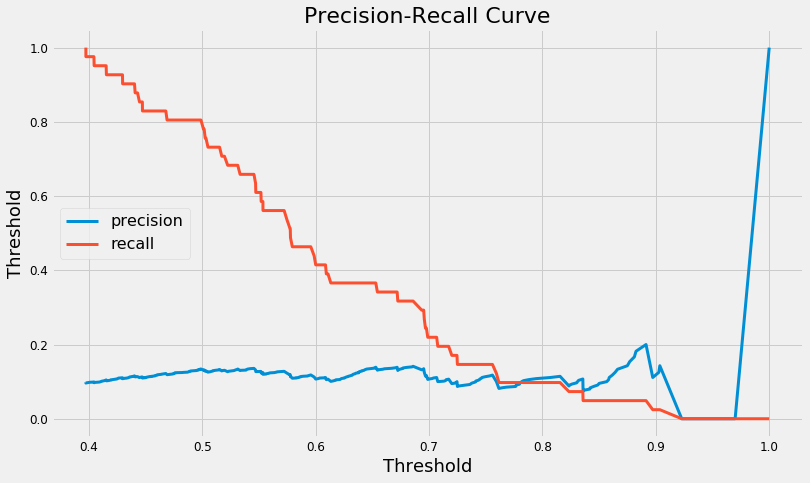

In [154]:
plt.plot(np.append(log_thresh, 1), log_pre, label='precision')
plt.plot(np.append(log_thresh, 1), log_rec, label='recall')
plt.xlabel('Threshold')
plt.ylabel('Threshold')
plt.title('Precision-Recall Curve')
plt.legend();

#### Receiver Operating Characteristic (ROC)

In [158]:
# create ROC curve data
# returns false positive rate, true positive rate for range of thresholds
log_fpr, log_tpr, log_thresh = roc_curve(y_test, log_predict_proba)

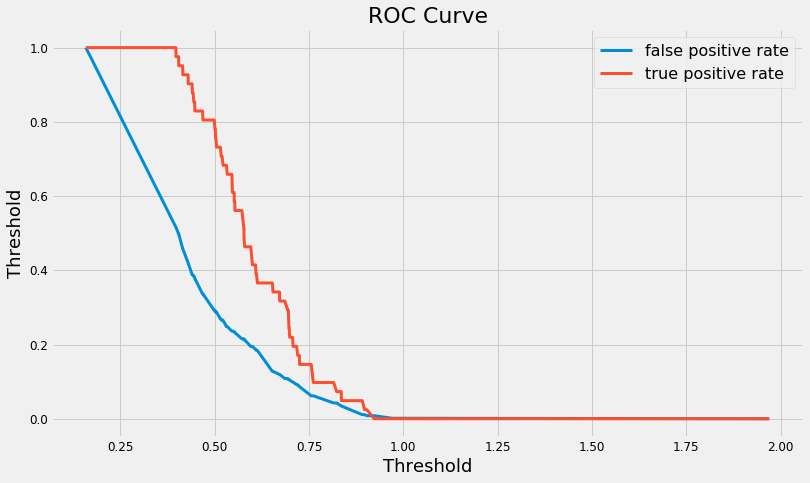

In [163]:
plt.plot(log_thresh, log_fpr, label='false positive rate')
plt.plot(log_thresh, log_tpr, label='true positive rate')
plt.xlabel('Threshold')
plt.ylabel('Threshold')
plt.title('ROC Curve')
plt.legend();

# OLD!

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

## Logistic Regression

### Initial Model

In [21]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train_mod, y_train_mod)
y_pred = logreg.predict(X_test_mod)

In [22]:
print(metrics.classification_report(y_test_mod, y_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       876
          1       0.00      0.00      0.00        48

avg / total       0.90      0.95      0.92       924



/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
metrics.confusion_matrix(y_test_mod, y_pred)

array([[876,   0],
       [ 48,   0]])

### Precision/Recall

In [24]:
y_prob_logreg = logreg.predict_proba(X_test_mod)[:,1]

In [25]:
# for plot

logreg_p, logreg_r, logreg_t = precision_recall_curve(y_test_mod, y_prob_logreg)

### Grid Search

In [26]:
# try parameter on best model
param_grid = {'C': np.logspace(-5, 5, 100)}
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring="recall")

In [27]:
best_model = grid_search.fit(X_train_mod, y_train_mod)

In [28]:
grid_search.best_params_

{'C': 0.3511191734215127}

In [29]:
logreg_grid = LogisticRegression(C=0.3511191734215127)
logreg_grid.fit(X_train_mod, y_train_mod)
y_pred = logreg_grid.predict(X_test_mod)

In [30]:
print(metrics.classification_report(y_test_mod, y_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       876
          1       0.00      0.00      0.00        48

avg / total       0.90      0.95      0.92       924



/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Threshold Model

In [31]:
y_pred_proba = logreg_grid.predict_proba(X_test_mod)

In [32]:
y_pred = y_pred_proba >= 0.1

In [33]:
print(metrics.classification_report(y_test_mod, y_pred[:, 1]))

             precision    recall  f1-score   support

          0       0.96      0.89      0.93       876
          1       0.15      0.33      0.20        48

avg / total       0.92      0.86      0.89       924



In [34]:
metrics.confusion_matrix(y_test_mod, y_pred[:, 1])

array([[783,  93],
       [ 32,  16]])

### Weighted Model

In [35]:
logreg_wgt = LogisticRegression(C=0.3511191734215127, class_weight="balanced")
logreg_wgt.fit(X_train_mod, y_train_mod)
y_pred = logreg_wgt.predict(X_test_mod)

In [36]:
print(metrics.classification_report(y_test_mod, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.77      0.86       876
          1       0.14      0.69      0.23        48

avg / total       0.93      0.77      0.83       924



In [37]:
metrics.confusion_matrix(y_test_mod, y_pred)

array([[674, 202],
       [ 15,  33]])

In [38]:
y_prob_logreg_wgt = logreg_wgt.predict_proba(X_test_mod)[:,1]

In [39]:
logreg_wgt_p, logreg_wgt_r, logreg_wgt_t = precision_recall_curve(y_test_mod, y_prob_logreg_wgt)

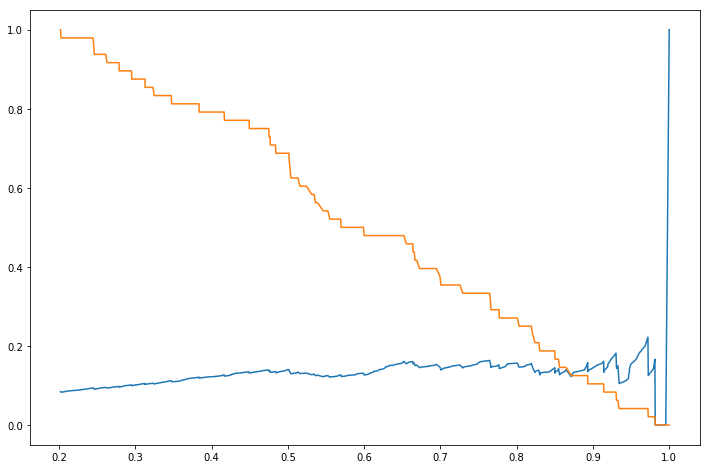

In [40]:
plt.plot(np.append(logreg_wgt_t, 1), logreg_wgt_p)
plt.plot(np.append(logreg_wgt_t, 1), logreg_wgt_r);

In [41]:
y_pred_proba = logreg_wgt.predict_proba(X_test_mod)

In [42]:
y_pred = y_pred_proba >= 0.5

In [43]:
metrics.confusion_matrix(y_test_mod, y_pred[:,1])

array([[674, 202],
       [ 15,  33]])

In [44]:
print(metrics.classification_report(y_test_mod, y_pred[:, 1]))

             precision    recall  f1-score   support

          0       0.98      0.77      0.86       876
          1       0.14      0.69      0.23        48

avg / total       0.93      0.77      0.83       924



In [45]:
y_pred_proba = logreg_wgt.predict_proba(X_test_mod)

In [46]:
y_pred = y_pred_proba >= 0.3

In [47]:
metrics.confusion_matrix(y_test_mod, y_pred[:,1])

array([[505, 371],
       [  6,  42]])

In [48]:
print(metrics.classification_report(y_test_mod, y_pred[:, 1]))

             precision    recall  f1-score   support

          0       0.99      0.58      0.73       876
          1       0.10      0.88      0.18        48

avg / total       0.94      0.59      0.70       924



In [49]:
y_pred_proba = logreg_wgt.predict_proba(X_test_mod)

In [50]:
y_pred = y_pred_proba >= 0.20

In [51]:
metrics.confusion_matrix(y_test_mod, y_pred[:,1])

array([[351, 525],
       [  0,  48]])

In [52]:
print(metrics.classification_report(y_test_mod, y_pred[:, 1]))

             precision    recall  f1-score   support

          0       1.00      0.40      0.57       876
          1       0.08      1.00      0.15        48

avg / total       0.95      0.43      0.55       924



### SMOTE

In [53]:
logreg_smote = LogisticRegression(C=0.3511191734215127)
logreg_smote.fit(X_train_smote, y_train_smote)
y_pred = logreg_smote.predict(X_test_smote)

In [54]:
print(metrics.classification_report(y_test_smote, y_pred))

             precision    recall  f1-score   support

          0       0.97      0.78      0.86       876
          1       0.13      0.60      0.21        48

avg / total       0.93      0.77      0.83       924



### Feature Importance

In [55]:
logreg_wgt.coef_

array([[-0.86139946, -0.5356733 ,  1.06441557,  0.09853371, -1.16323717,
         0.22393825,  0.15048069, -0.17791089,  0.5699169 ,  1.48526821,
        -0.69534937, -0.94675162,  0.37327196]])

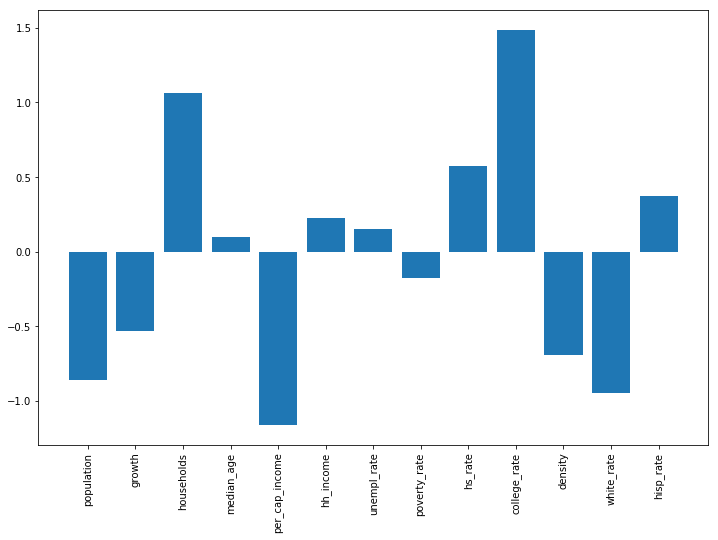

In [56]:
plt.bar(df.columns[0:-1], logreg_wgt.coef_[0])
plt.xticks(rotation=90);

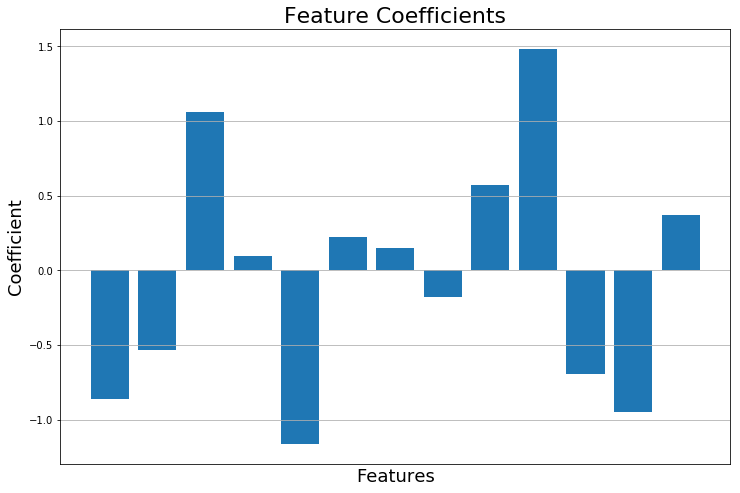

In [57]:
plt.bar(df.columns[0:-1], logreg_wgt.coef_[0])
#plt.xticks(rotation=90)
plt.xticks([])
plt.xlabel('Features', fontsize=18)
plt.ylabel('Coefficient', fontsize=18)
plt.title('Feature Coefficients', fontsize=22)
plt.grid()
# plt.savefig("presentation/feat.png")

In [58]:
log_feat = logreg_grid.coef_

In [59]:
log_feat_order = np.argsort(np.abs(log_feat.flat))[::-1]
betas = list(zip(X.columns[log_feat_order],log_feat.flat[log_feat_order]))

In [60]:
betas[0][0]

'college_rate'

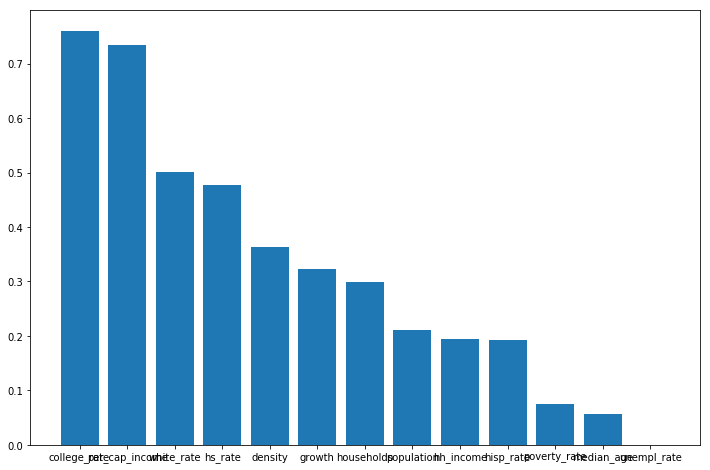

In [61]:
plt.bar(df.columns[0:-1][log_feat_order], abs(logreg_grid.coef_[0][log_feat_order]));

## Random Forest

### Initial Model

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train_mod, y_train_mod)
y_pred = random_forest.predict(X_test_mod)

In [64]:
print(metrics.classification_report(y_test_mod, y_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       876
          1       0.00      0.00      0.00        48

avg / total       0.90      0.95      0.92       924



In [65]:
metrics.confusion_matrix(y_test_mod, y_pred)

array([[874,   2],
       [ 48,   0]])

In [66]:
y_scores = cross_val_predict(random_forest, X_train_mod, y_train_mod, cv=10)
np.mean(y_scores)

0.0018561484918793504

### Grid Search

In [67]:
# try on best model
param_grid = {'n_estimators': range(20, 40), 'max_features': np.linspace(1, 40, 1)}
grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring="recall")

In [68]:
best_model = grid_search.fit(X_train_mod, y_train_mod)

In [69]:
grid_search.best_params_

{'max_features': 1.0, 'n_estimators': 21}

In [70]:
random_forest_grid = RandomForestClassifier(max_features=1, n_estimators=25)
random_forest_grid.fit(X_train_mod, y_train_mod)
y_pred = random_forest_grid.predict(X_test_mod)

In [71]:
print(metrics.classification_report(y_test_mod, y_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       876
          1       0.00      0.00      0.00        48

avg / total       0.90      0.95      0.92       924



/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Precision/Recall

In [72]:
y_prob_random_forest = random_forest.predict_proba(X_test_mod)[:, 1]

In [73]:
random_forest_p, random_forest_r, random_forest_t = precision_recall_curve(y_test_mod, y_prob_random_forest)

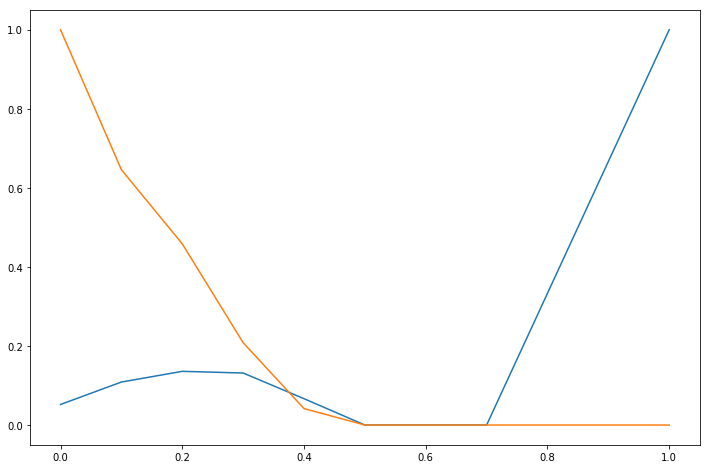

In [74]:
plt.plot(np.append(random_forest_t, 1), random_forest_p)
plt.plot(np.append(random_forest_t, 1), random_forest_r);

### Threshold Model

In [75]:
y_pred_proba = random_forest.predict_proba(X_test_mod)

In [76]:
y_pred = y_pred_proba >= 0.1

In [77]:
metrics.confusion_matrix(y_test_mod, y_pred[:, 1])

array([[622, 254],
       [ 17,  31]])

In [78]:
print(metrics.classification_report(y_test_mod, y_pred[:, 1]))

             precision    recall  f1-score   support

          0       0.97      0.71      0.82       876
          1       0.11      0.65      0.19        48

avg / total       0.93      0.71      0.79       924



### Weighted Model

In [79]:
random_forest = RandomForestClassifier(class_weight="balanced")
random_forest.fit(X_train_mod, y_train_mod)
y_pred = random_forest.predict(X_test_mod)

In [80]:
print(metrics.classification_report(y_test_mod, y_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       876
          1       0.00      0.00      0.00        48

avg / total       0.90      0.95      0.92       924



### SMOTE

In [81]:
random_forest_smote = RandomForestClassifier()
random_forest_smote.fit(X_train_smote, y_train_smote)
y_pred = random_forest_smote.predict(X_test_smote)

In [82]:
print(metrics.classification_report(y_test_smote, y_pred))

             precision    recall  f1-score   support

          0       0.95      0.93      0.94       876
          1       0.12      0.17      0.14        48

avg / total       0.91      0.89      0.90       924



## SVM

### Initial Model

In [83]:
from sklearn import svm

In [84]:
rbf_svm = svm.SVC(kernel='rbf', probability=True)
rbf_svm.fit(X_train_mod, y_train_mod)
y_pred = rbf_svm.predict(X_test_mod)

In [85]:
print(metrics.classification_report(y_test_mod, y_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       876
          1       0.00      0.00      0.00        48

avg / total       0.90      0.95      0.92       924



/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [86]:
metrics.confusion_matrix(y_test, y_pred)

array([[876,   0],
       [ 48,   0]])

In [87]:
y_scores = cross_val_predict(rbf_svm, X_train_mod, y_train_mod, cv=10)
np.mean(y_scores)

0.0

### Precision/Recall

In [88]:
y_prob_svm = rbf_svm.predict_proba(X_test_mod)[:,1]

In [89]:
rbf_svm_p, rbf_svm_r, rbf_svm_t = precision_recall_curve(y_test_mod, y_prob_svm)

## KNN

In [90]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection

In [91]:
# search for an optimal value of K for KNN

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_mod, y_train_mod)
y_pred = knn.predict(X_test_mod)

In [92]:
print(metrics.classification_report(y_test_mod, y_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       876
          1       0.00      0.00      0.00        48

avg / total       0.90      0.95      0.92       924



In [93]:
metrics.confusion_matrix(y_test_mod, y_pred)

array([[875,   1],
       [ 48,   0]])

In [94]:
y_scores = cross_val_predict(knn, X_train_mod, y_train_mod, cv=10)
np.mean(y_scores)

0.0

### Precision/Recall

In [95]:
y_prob_knn = knn.predict_proba(X_test_mod)[:,1]

In [96]:
knn_p, knn_r, knn_t = precision_recall_curve(y_test_mod, y_prob_knn)

## Gaussian-Bayes

### Initial Model

In [97]:
from sklearn import naive_bayes, metrics

In [98]:
gb = naive_bayes.GaussianNB()
gb.fit(X_train_mod, y_train_mod)
y_pred = gb.predict(X_test_mod)

In [99]:
print(metrics.classification_report(y_test_mod, y_pred))

             precision    recall  f1-score   support

          0       0.95      0.91      0.93       876
          1       0.11      0.19      0.14        48

avg / total       0.91      0.88      0.89       924



In [100]:
metrics.confusion_matrix(y_test_mod, y_pred)

array([[801,  75],
       [ 39,   9]])

In [101]:
y_scores = cross_val_predict(gb, X_train_mod, y_train_mod, cv=10)
np.mean(y_scores)

0.09791183294663573

### Precision/Recall

In [102]:
y_prob_gb = gb.predict_proba(X_test_mod)[:, 1]

In [103]:
gb_p, gb_r, gb_t = precision_recall_curve(y_test_mod, y_prob_gb)

## Precision-Recall Plot

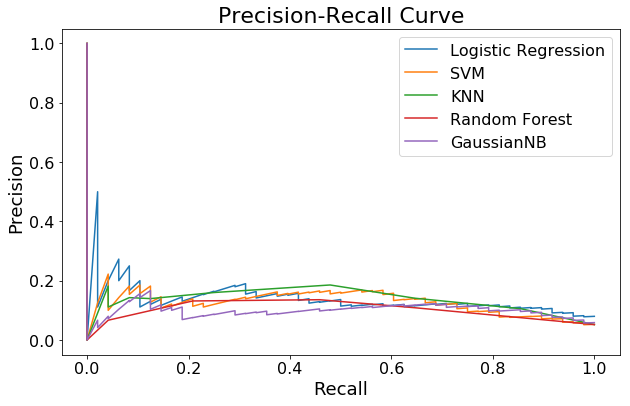

In [104]:
# plot P-R for all models

fig, ax = plt.subplots(figsize=(10, 6))

# Logisitic Regression
ax.plot(logreg_r, logreg_p, label='Logistic Regression')
# SVM
ax.plot(rbf_svm_r, rbf_svm_p, label='SVM')
#ax.step(rbf_svm_r, rbf_svm_p, color='b', alpha=0.2, where='post')
#ax.fill_between(rbf_svm_r, rbf_svm_p, step='post', alpha=0.2, color='b')
# KNN
ax.plot(knn_r, knn_p, label='KNN')
# Random Forest
ax.plot(random_forest_r, random_forest_p, label='Random Forest')
# Gaussian-Bayes
ax.plot(gb_r, gb_p, label='GaussianNB')

# ax.set_xlim(0, 1.01)
# ax.set_ylim(0, 1)
ax.set_title('Precision-Recall Curve', fontsize=22)
ax.set_ylabel('Precision', fontsize=18)
ax.set_xlabel('Recall', fontsize=18)
ax.legend(loc='upper right', fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)

plt.show()
# fig.savefig("presentation/prcurve.png")

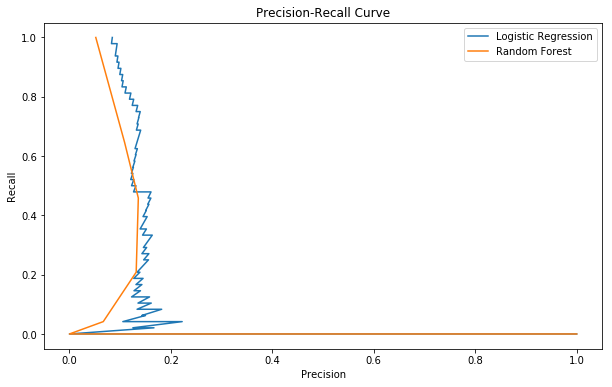

In [105]:
fig, ax = plt.subplots(figsize=(10, 6))

# Logisitic Regression
ax.plot(logreg_wgt_p, logreg_wgt_r, label='Logistic Regression')
# SVM
# ax.plot(rbf_svm_p, rbf_svm_r, label='SVM')
#ax.step(rbf_svm_r, rbf_svm_p, color='b', alpha=0.2, where='post')
#ax.fill_between(rbf_svm_r, rbf_svm_p, step='post', alpha=0.2, color='b')
# KNN
# ax.plot(knn_p, knn_r, label='KNN')
# Random Forest
ax.plot(random_forest_p, random_forest_r, label='Random Forest')
# Gaussian-Bayes
# ax.plot(gb_p, gb_r, label='GaussianNB')

# ax.set_xlim(0, 1.01)
# ax.set_ylim(0, 1)
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Recall')
ax.set_xlabel('Precision')
ax.legend(loc='upper right')

plt.show()